In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats

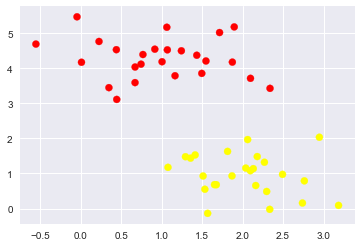

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

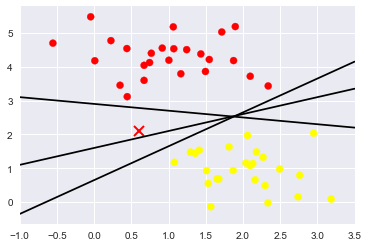

In [3]:
#plot the data
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

# plot separating lines
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

In [4]:
#  the model
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)
#model?

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [5]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

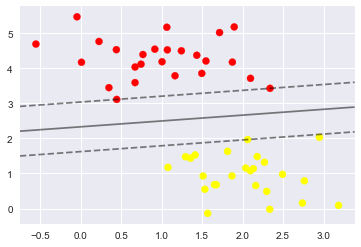

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

 # non linear kernel 

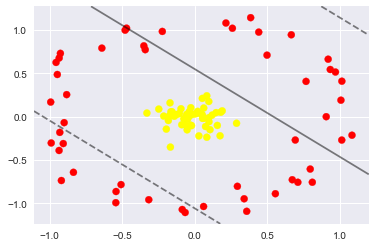

In [7]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Text(0.5, 1.0, 'N = 60')

Text(0.5, 1.0, 'N = 120')

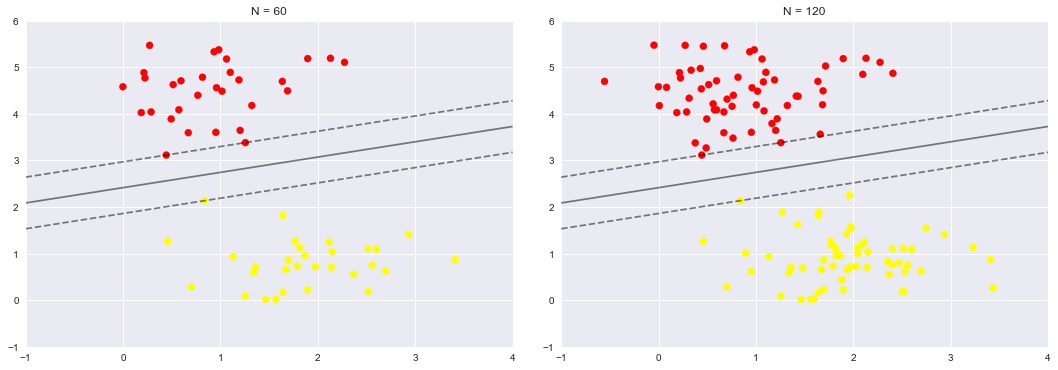

In [8]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

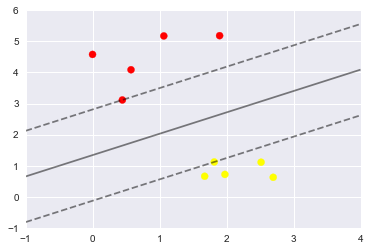

<function __main__.plot_svm(N=10, ax=None)>

In [11]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));
r = np.exp(-(X ** 2).sum(1))

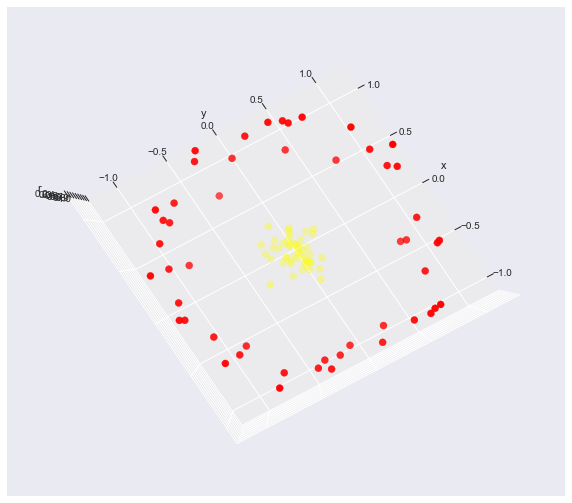

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    plt.figure(figsize=(10, 9))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

# Evaluating model results 

**P** - Real positive condition  

**N** - Real condition negative

**TP** - True positive  - positive hit 

**TN** - True negative - negative hit

**FP** - False positive miss (realitiy is negative)

**FN** - False negative - negative miss (reality is positive)

Examples will be given in medical case: we have a population of sick and healthy patients. We want to evaluate effectivness of a test. 


**(TPR) True positive rate** or _sensitivity_ or hit rate  - _probablity of detection a positive test result for a sick patient_ This is the goal! We want to have this as cloase to 1 as possible. It can't be more than 1. If TPR is low it means a lot of False Negative. it means we miss a lot !

$$ TPR = \frac{TP(True~Positive~hit)}{P( REAL~Positive)} = \frac{TP}{TP+FN}$$ 

**(TNR) True negative rate** _specificity_ - 
_probability of a negative test rezult for a good patient_
$$ TNR=\frac{TN}{N}=\frac{TN}{TN+FP} $$
If this one is low it means a lot of False Positive. so the test  gives a lot of false alarm.

**FPR**  -  False positive rate, fall out
$$FPR=\frac{FP}{FP+TN}={1-TNR}$$

**Precision** - positive predictive value - 
 
 $$PPV=\frac{TP}{TP+FP}=\frac{TP}{All~Predicted~Positive}$$

PPV depends on precent of positve cases in  population. Precision ( True Positives / (True Positives + False Positives) ) is highly sensitive to False Positives and is not impacted by a large total real negative denominator. 


Values ensitivity and specificity are agnostic to the percent of positive cases in the population 
PR- precigion
RC- recall 

$$ F1 = 2* \frac {PPV*TPR}{PPV+TPR}=({PPV}^-1 + {TPR}^-1)^-1 $$

**Real values for F1** 
ideal (not possible)
PR= 1, RC=1
F1= 1
Closer to reality: 
PR=0.75 (significant false positive)  RC=0.85 (some false negative)
F1=2*(0.75*0.85)/(0.75+0.85)=0.796

## Receiver operating characteristic (ROC) and  Total Operating Characteristic (TOC)

ROC is a  graphical plot that illustrates diagnostic ability of a binary  classifier system as its discrimination treshold is varied. 

ROC curve created by plotting True positve rate (TPR) against False positive rate (FPR) at various treshold settings or ROC reveals two ratios, TP/(TP + FN) and FP/(FP + TN).  

Given Treshhold parameter T for continues random observation _X_ if it belongs to cleaa positive 

$$ TPR(T) = \int_T^{\infty}f_1(x)dx$$


TOC shows the total information in the contingency table for each threshold
For each threshold, ROC reveals two ratios, TP/(TP + FN) and FP/(FP + TN). 

$$\sum_{i=1}^{2n}=n*\frac{n+1}{n-1}$$
$$\frac{du}{dt}$$
$$\int_0^{r}f(x)dx$$


In [4]:
import numpy as np
from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision
recall
thresholds


array([ 0.35,  0.4 ,  0.8 ])

In [5]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(X[y < 2], y[y < 2],
                                                    test_size=.5,
                                                    random_state=random_state)

# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

In [6]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.88


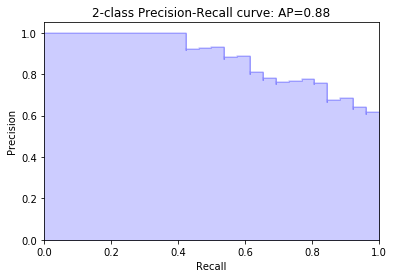

In [9]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [11]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.029) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 100, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model 

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.97      1.00      0.98        90
           2       0.99      0.98      0.98        92
           3       1.00      0.99      0.99        93
           4       1.00      1.00      1.00        76
           5       0.99      0.98      0.99       108
           6       0.99      1.00      0.99        89
           7       0.99      1.00      0.99        78
           8       1.00      0.98      0.99        92
           9       0.99      0.99      0.99        92

   micro avg       0.99      0.99      0.99       899
   macro avg       0.99      0.99      0.99       899
weighted avg       0.99      0.99      0.99       899



Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[ 1.    0.    0.  ]
 [ 0.    0.62  0.38]
 [ 0.    0.    1.  ]]


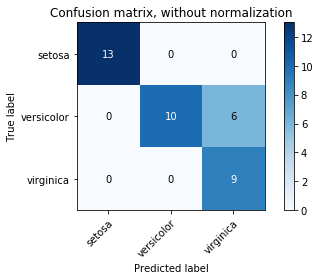

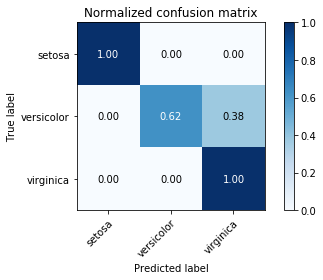

In [15]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

- [x] Result
  - [ ] TP
  - [x] max (Positive)
  - [x] min(False Negative)
  - [ ] $$  

AUC: 0.895


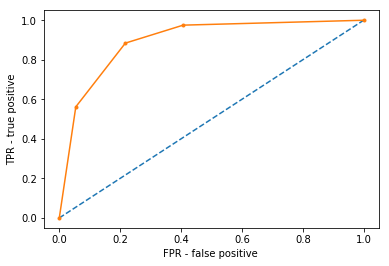

In [26]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainy)
# predict probabilities
probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(testy, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(testy, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
pyplot.xlabel('FPR - false positive ')
pyplot.ylabel('TPR - true positive')
# show the plot
pyplot.show()

f1=0.278 auc=0.302 ap=0.236


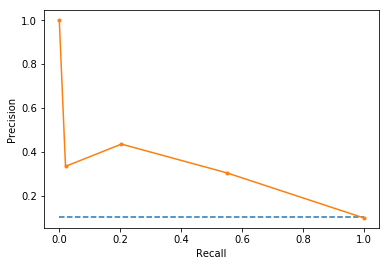

In [18]:
# precision-recall curve and auc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.9,0.09], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainy)
# predict probabilities
probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = model.predict(testX)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, probs)
# calculate F1 score
f1 = f1_score(testy, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(testy, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the plot
pyplot.show()

In [25]:
#z=[[0,1,2][3,4,5]]
print(X[1,-1])

-0.376085779253
